# Examples for OptPulseProcessor

In [1]:
from qutip.qip.models.optpulseprocessor import OptPulseProcessor
from qutip.qip import QubitCircuit, expand_operator
from qutip import sigmaz, sigmax, basis, fidelity, identity, toffoli, tensor

The `qutip.OptPulseProcessor` is a the simulator integrated with the optimal pulse algorithm from the `qutip.control` module. It is a subclass of `qutip.Circuitprocessor` and is equipted with a method to transfer a `qutip.QubitCircuit` or a list of `qutip.Qobj` into a pulse sequence.

## Single-qubit gate
Like the `Circuitprocessor`, we need to first define the available Hamiltonians in the system. The `OptPulseProcessor` has one more parameter, that is the drift Hamiltonian, who has no time-dependent coefficients and thus won't be optimized.

In [2]:
N = 1
# Drift Hamiltonian
H_d = sigmaz()
# The (single) control Hamiltonian
H_c = [sigmax()]
processor = OptPulseProcessor(N, drift=H_d, ctrls=H_c)

The method load_circuit calls `qutip.control.optimize_pulse_unitary` and return the pulse coefficients.

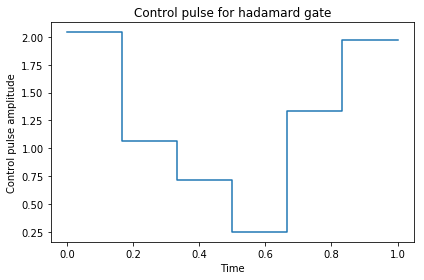

In [3]:
qc = QubitCircuit(N)
qc.add_gate("SNOT", 0)

# This method calls optimize_pulse_unitary
tlist, coeffs = processor.load_circuit(qc, n_ts=6, evo_time=1, min_grad=1e-20, init_pulse_type='RND')
processor.plot_pulses(title="Control pulse for hadamard gate");

Like the `CircuitProcessor`, the simulation is calculated with the QuTiP solver. The method `run_state` calls `mesolve` and return the result. One can also add noise to see the change in the fidelity.

In [4]:
rho0 = basis(2,1)
plus = (basis(2,0) + basis(2,1)).unit()
minus = (basis(2,0) - basis(2,1)).unit()
result = processor.run_state(rho0=rho0)
result.states[-3]
print("Fidelity:", fidelity(result.states[-1], minus))

# add noise
processor.T1 = 40.0
result = processor.run_state(rho0=rho0)
print("Fidelity with qubit relaxation:", fidelity(result.states[-1], minus))

Fidelity: 0.9999999998003306
Fidelity with qubit relaxation: 0.9934042984563827


## Multi-qubit gate

In the following example, we use `OptPulseProcessor` to find the optmal control pulse of a multi-qubit circuit. For simplicity, the circuit contains only one toffoli gate.

In [5]:
toffoli()

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

We have single qubit control $\sigma_x$ and $\sigma_z$, with the argument `expand_type="periodic"`, it creates 3 operators each targeted on one qubit.

In [6]:
N = 3
H_d = tensor([identity(2)] * 3)
test_processor = OptPulseProcessor(N, H_d, [])
test_processor.add_ctrl(sigmaz(), cyclic_permutation=True)
test_processor.add_ctrl(sigmax(), cyclic_permutation=True)

The interaction is generated by $\sigma_x\sigma_x$ between the qubit 0 & 1 and qubit 1 & 2. `expand_operator` can be used to expand the operator to a larger dimension with given target qubits.

In [7]:
sxsx = tensor([sigmax(),sigmax()])
sxsx01 = expand_operator(sxsx, N=3, targets=[0,1])
sxsx12 = expand_operator(sxsx, N=3, targets=[1,2])
test_processor.add_ctrl(sxsx01)
test_processor.add_ctrl(sxsx12)

Find the optimal pulse with 6 time slots. Instead of a `QubitCircuit`, a list of operators can also be given as an input.

********** Gate 0 **********
Final fidelity error 5.0515255867189524e-08
Final gradient normal 1.9023844430824243e-05
Terminated due to Iteration or fidelity function call limit reached
Number of iterations 500


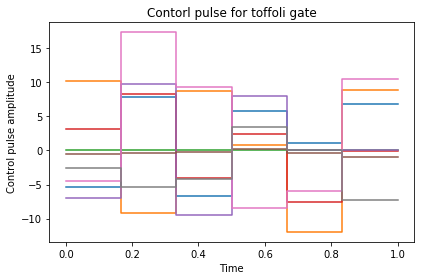

In [8]:
test_processor.load_circuit([toffoli()], n_ts=6, evo_time=1, verbose=True);
test_processor.plot_pulses(title="Contorl pulse for toffoli gate");

In [9]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.0.dev0+c50c4bc9
Numpy,1.16.2
SciPy,1.2.1
matplotlib,3.0.3
Cython,0.29.12
Number of CPUs,12
BLAS Info,INTEL MKL
IPython,7.4.0
Python,"3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]"
OS,nt [win32]
